In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from copy import copy
import os
import numpy as np
import pandas as pd
import case_config

In [2]:
plt.style.use("./rlearn.mplstyle")

In [3]:
DATA_ROOT = "/Users/mho/Dropbox/phd/readdy_learn/reaction_learn_data"
#DATA_ROOT = "/home/mi/chrisfr/Dropbox/readdy_learn/reaction_learn_data"

47
47
n_frames=667, n_species=9
47
47
n_frames=667, n_species=9


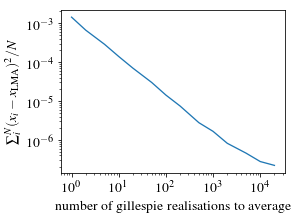

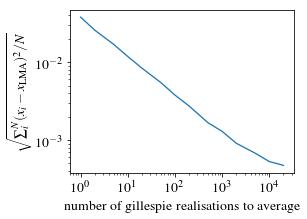

In [10]:
gillespie_realizations = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
noisy_species = np.array([2,1,5,4,8,7])
def get_lma_counts(init=1):
    regulation_network, analysis = case_config.get_regulation_network_lma(init=init)
    traj = analysis.get_traj(0)
    return traj.counts, traj.dcounts_dt, traj.time_step

# get noisefree solution
lma_counts_init1, _, _ = get_lma_counts(init=1)
lma_counts_init3, _, _ = get_lma_counts(init=3)
lma_counts = np.concatenate((lma_counts_init1, lma_counts_init3), axis=0)
lma_counts = lma_counts[:, noisy_species]

# calculate mean squared deviation
n_gill = 1
iid = 0
noise_level = np.zeros(len(gillespie_realizations))
for i_gill, number_gill in enumerate(gillespie_realizations):
    mses = []
    for iid in range(10):
        counts, _ = case_config.get_traj_from_file(os.path.join(DATA_ROOT, "gillespie_trajs_conced_1_3_normal.h5"), 
                                                   number_gill, iid)
        counts = counts[:, noisy_species]
        n_samples = counts.size
        mse = np.sum(np.power(counts - lma_counts, 2)) / n_samples
        mses.append(mse)
    mses = np.array(mses)
    noise_level[i_gill] = np.mean(mses)

# gillespie realizations -> noise level relation
plt.plot(gillespie_realizations, noise_level)
plt.xlabel("number of gillespie realisations to average")
plt.ylabel(r"$\sum^N_i (x_i -x_\mathrm{LMA})^2/N$")
plt.yscale("log")
plt.xscale("log")
plt.show()
plt.plot(gillespie_realizations, np.sqrt(noise_level))
plt.xlabel("number of gillespie realisations to average")
plt.ylabel(r"$\sqrt{\sum^N_i (x_i -x_\mathrm{LMA})^2/N}$")
plt.yscale("log")
plt.xscale("log")
plt.show()

In [11]:
def load(file):
    with open(os.path.join(DATA_ROOT, file), 'rb') as f:
        X = np.load(f)
        rates = X['rates']
        l1_dev = X['l1_dev']
        alpha_val = X['alpha_val']
        gillespie_realizations = X['gillespie_realisations']
        desired_rates = X['desired_rates']
        assert np.allclose(desired_rates, case_config.DESIRED_RATES)
    return rates, l1_dev, alpha_val, gillespie_realizations, desired_rates

#### "Normal"

In [12]:
# rates_normal, l1_normal, alpha_normal, gillespie_realizations_normal, _ = load('case3_validation_alphas_and_solutions_averagefolds_normaltraj_20folds.npz')

#### "Zipped"

In [13]:
rates_normal, l1_normal, alpha_normal, gillespie_realizations_normal, _ = load('case3_validation_alphas_and_solutions_averagefolds_zippedtraj_20folds.npz')

In [14]:
# assert all(gillespie_realizations_normal == gillespie_realizations_zipped)
gillespie_realizations = gillespie_realizations_normal

In [15]:
with open(os.path.join(DATA_ROOT, 'case3_solutions_lsq_zippedtraj.npz'), 'rb') as f:
    X = np.load(f)
    lsq_rates = X['rates']
    lsq_l1_dev = X['l1_dev']
    lsq_alpha_val = X['alpha_val']
    assert all(gillespie_realizations == X['gillespie_realisations'])

In [28]:
def plot_failure_rates(ax):
    failure_rates = []
    failure_rates_std = []
    lsq_failure_rates = []
    lsq_failure_rates_std = []
    for gillespie_realization in range(len(gillespie_realizations)):
        estimated_rates = rates_normal[gillespie_realization]
        r = [case_config.failure_rate(x) for x in estimated_rates]
        failure_rates.append(np.mean(r))
        failure_rates_std.append(np.std(r))
        r = [case_config.failure_rate(x) for x in lsq_rates[gillespie_realization]]
        lsq_failure_rates.append(np.mean(r))
        lsq_failure_rates_std.append(np.std(r))
        
    failure_rates = np.array(failure_rates)
    failure_rates_std = np.array(failure_rates_std)
    lsq_failure_rates = np.array(lsq_failure_rates)
    lsq_failure_rates_std = np.array(lsq_failure_rates_std)
    
    #x_data = gillespie_realizations
    x_data = noise_level
    
    ax.plot(x_data, failure_rates, label='Failure rate (regularized)')
    ax.fill_between(x_data, y1=failure_rates-failure_rates_std, y2=failure_rates+failure_rates_std, alpha=0.3)
    ax.plot(x_data, lsq_failure_rates, label='Failure rate (LSQ)')
    ax.fill_between(x_data, y1=lsq_failure_rates-lsq_failure_rates_std, y2=lsq_failure_rates+lsq_failure_rates_std, alpha=.3)
    ax.plot(x_data, [0]*len(x_data), '--', color='xkcd:eggplant', label='Optimal value')
    ax.set_xscale('log')
    # ax.set_xlabel('Noise level')
    ax.set_ylabel('Failure rate')
    ax.legend()
    # ax.legend(loc='center left', bbox_to_anchor=(1, .5))

In [29]:
def plot_l1_difference(l1_err, l1_err_lsq, ax):
    mean = np.mean(l1_err, axis=1)
    err = np.std(l1_err, axis=1) #/ np.sqrt(10.) # 10 iids
    mean_lsq = np.mean(l1_err_lsq, axis=1)
    err_lsq = np.std(l1_err_lsq, axis=1)
    
    #x_data = gillespie_realizations
    x_data = noise_level
    
    ax.plot(x_data, mean, label='Estimation error (regularized)')
    ax.fill_between(x_data, y1=np.clip(mean-err, 0., 1e16), y2=mean+err, alpha=0.3)
    ax.plot(x_data, mean_lsq, label='Estimation error (LSQ)')
    ax.fill_between(x_data, y1=np.clip(mean_lsq-err_lsq, 0., 1e16), y2=mean_lsq+err_lsq, alpha=0.3)
    ax.set_xscale("log")
    ax.set_xlabel("Noise level")
    ax.set_ylabel(r"$|\xi-\hat{\xi}|_1$")
    ax.legend()
    # ax.legend(loc='center left', bbox_to_anchor=(1, .5))

In [30]:
traj = case_config.get_traj_from_file(os.path.join(DATA_ROOT, "gillespie_trajs_conced_1_3_normal.h5"), 1, 0)

In [31]:
t = np.arange(len(traj[0])) * case_config.TIMESTEP
stride = 1

def plot_species(ax, species):
    plot_format = ["-", "--"] * 6
    for ix, s in enumerate(species):
        name = case_config.SPECIES_TEX[s]

        half = len(t)//2
        ax.plot(t[:half:stride], traj[0][:, s][:half:stride], plot_format[ix], label=r"${}$".format(name), color="black")
        ax.plot(t[half::stride], traj[0][:, s][half::stride], plot_format[ix], color="black")


# width = 7.1 # double columns
#width = 7.1 / 2.  # single column
#width = 4.5
#n_rows = 3
#height = n_rows * 1.3
##n_cols = 1

#fig, (ax1, ax2, ax3) = plt.subplots(n_rows, n_cols, figsize=(width, height), sharex=True)


#plt.ylabel('Concentration in a.u.')


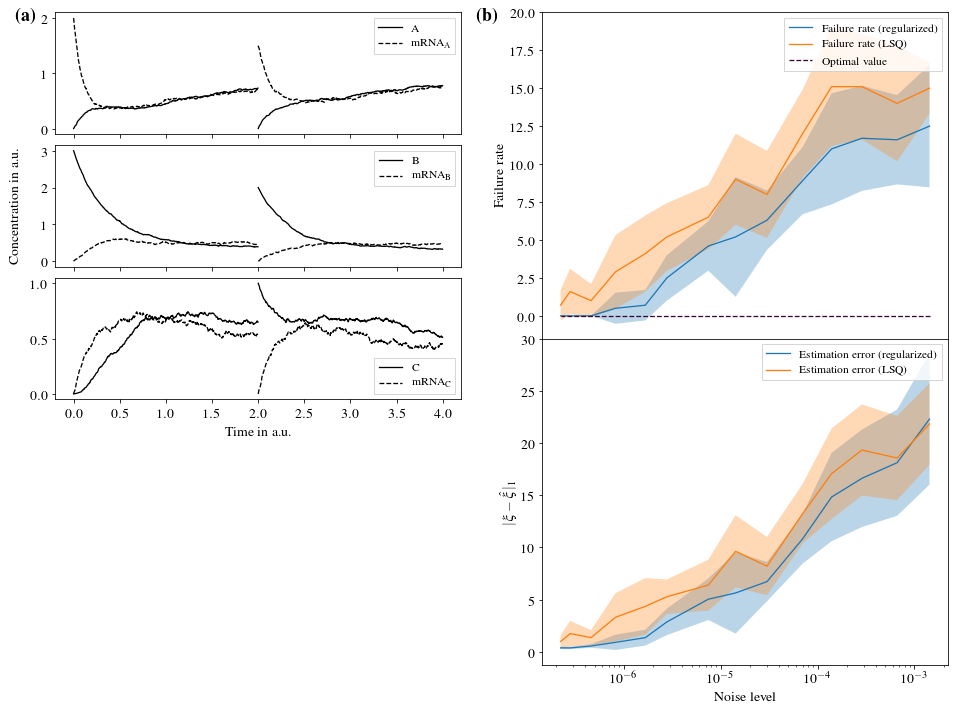

In [32]:
f = plt.figure(figsize=[4*x for x in plt.rcParams.get('figure.figsize')])

gs = GridSpec(10, 2)
ax1 = plt.subplot(gs[0:2, 0])
ax2 = plt.subplot(gs[2:4, 0], sharex=ax1)
ax3 = plt.subplot(gs[4:6, 0], sharex=ax1)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

plot_species(ax1, np.array([2, 1]))
ax1.legend()
plot_species(ax2, np.array([5, 4]))
ax2.set_ylabel('Concentration in a.u.', labelpad=20)
ax2.legend()
plot_species(ax3, np.array([8, 7]))
ax3.set_xlabel('Time in a.u.')
ax3.legend()

gs2 = GridSpec(10, 2)
gs2.update(hspace=0.)
ax4 = plt.subplot(gs2[0:5, 1])
ax5 = plt.subplot(gs2[5:10, 1])

plt.setp(ax4.get_xticklabels(), visible=False)

plot_failure_rates(ax4)
plot_l1_difference(l1_normal, lsq_l1_dev, ax5)

f.text(0.09, .87, r'\textbf{(a)}', fontdict={'size': plt.rcParams['font.size']+4})
f.text(0.49, .87, r'\textbf{(b)}', fontdict={'size': plt.rcParams['font.size']+4})

f.savefig("case3.pdf", bbox_inches="tight", transparent=True)

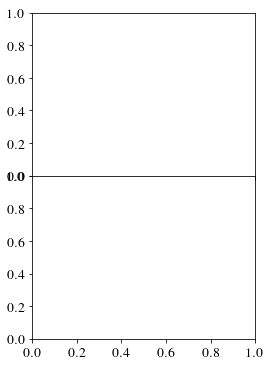

In [21]:
fs = copy(plt.rcParams.get('figure.figsize'))
fs[1] = 2*fs[1]
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=fs, sharex=True)



f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

f.savefig("case3.pdf", bbox_inches="tight", transparent=True)

In [11]:
# plot_l1_difference(l1_zipped, 'case3_convergence_averagefolds_zipped.pdf')

In [19]:
reg = np.mean(rates_normal[-1], axis=0)

In [20]:
traj = case_config.get_traj_from_file(os.path.join(DATA_ROOT, "gillespie_trajs_init_1.h5"), 20000, 0)

Text(0,0.5,'Concentration in a.u.')

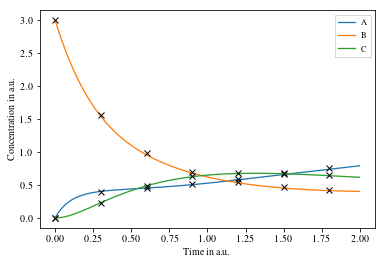

In [21]:
estimated_rates = reg[:]
estimated_rates[np.where(estimated_rates < case_config.CASE1_CUTOFF)] = 0
xs, ys = case_config.integrate(case_config.INITIAL_CONDITIONS[0], estimated_rates)

#species = np.array([1, 2, 4, 5, 7, 8])
species = np.array([2, 5, 8])
t = np.arange(len(traj[0]))*case_config.TIMESTEP
for ix, s in enumerate(species):
    name = case_config.SPECIES_TEX[s]
    plt.plot(t, traj[0][:,s], label=r"${}$".format(name), color='C{}'.format(ix))
    plt.plot(xs[::100], ys[:, s][::100], 'kx')
plt.legend()
plt.xlabel('Time in a.u.')
plt.ylabel('Concentration in a.u.')

In [23]:
traj = case_config.get_traj_from_file(os.path.join(DATA_ROOT, "gillespie_trajs_init_3.h5"), 20000, 0)

Text(0,0.5,'Concentration in a.u.')

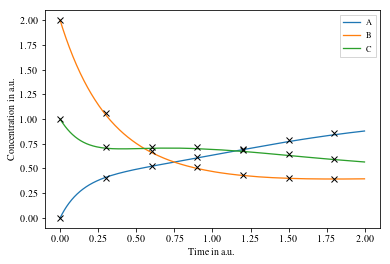

In [24]:
estimated_rates = reg[:]
estimated_rates[np.where(estimated_rates < case_config.CASE1_CUTOFF)] = 0
xs, ys = case_config.integrate(case_config.INITIAL_CONDITIONS[1], estimated_rates)

#species = np.array([1, 2, 4, 5, 7, 8])
species = np.array([2, 5, 8])
t = np.arange(len(traj[0]))*case_config.TIMESTEP
for ix, s in enumerate(species):
    name = case_config.SPECIES_TEX[s]
    plt.plot(t, traj[0][:,s], label=r"${}$".format(name), color='C{}'.format(ix))
    plt.plot(xs[::100], ys[:, s][::100], 'kx')
plt.legend()
plt.xlabel('Time in a.u.')
plt.ylabel('Concentration in a.u.')